# Tracking machine learning metrics with *mlmetrics*

Modern machine learning highly relies on understanding machine learning metrics. There are various libraries for tracking the training metrics existing already that provide detailed and compelling insights of the training process. Exaples of such libraries are Tensorboard and Weights & Biases. However, despite their useful outputs, these tools come with some complications. First, it is sometimes very untrivial to connect these tools, especially if training is happening on the remote machine. For example, in order to get training results on my local laptop for the model that I was training on Cori supercomputer (Lawrence Berley National Laboratory of the Department of State), I needed to perform the following actions:

- Install and run JupyterLab

- Bridge ports between JupyterLab and Tensorboard

- Bridge ports between JupyterLab running on Cori and my local laptop

- Connect to Jupyter Notebook with metrics on my laptop

Perofrming these steps is quite a complicated and time-consuming task, especially when the only thing that I needed to see were basic metrics, such as training and validation loss progression. This was my motivation to make my library for tracking ML metrics. A few important points that I tried to implement in my library:

- Usage must be extremely simple.

- It should provide basic metrics of training machine learning model in easy to interpret format.

- There must be a simple way to save the logs for sharing between devices.

You can find the library on GitHub <a href="https://github.com/Carterochka/mlmetrics">here</a>. Let's have a look on how it works.

# Importing data and setting up the model

To show how the library works, let's first import the data and create a neural network model. In this part, I repeated the steps and used all the setup code of Sanchit Tanwar from <a href="https://towardsdatascience.com/building-our-first-neural-network-in-keras-bdc8abbc17f5">his article</a> on TowardsDataScience. If you want to learn more, I suggest to take a look there.

First, let's import the Kaggle dataset that can be found <a href="https://www.kaggle.com/iabhishekofficial/mobile-price-classification">here</a>.

In [1]:
# Dependencies
import numpy as np
import pandas as pd
# Dataset import
dataset = pd.read_csv('data/train.csv') 
dataset.head(10)

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,...,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,...,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,...,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,...,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,...,1208,1212,1411,8,2,15,1,1,0,1
5,1859,0,0.5,1,3,0,22,0.7,164,1,...,1004,1654,1067,17,1,10,1,0,0,1
6,1821,0,1.7,0,4,1,10,0.8,139,8,...,381,1018,3220,13,8,18,1,0,1,3
7,1954,0,0.5,1,0,0,24,0.8,187,4,...,512,1149,700,16,3,5,1,1,1,0
8,1445,1,0.5,0,0,0,53,0.7,174,7,...,386,836,1099,17,1,20,1,0,0,0
9,509,1,0.6,1,2,1,9,0.1,93,5,...,1137,1224,513,19,10,12,1,0,0,0


We now can separate features and labels into different variables.

In [2]:
# Changing pandas dataframe to numpy array
X = dataset.iloc[:,:20].values
y = dataset.iloc[:,20:21].values

Let's further preprocess the data - by normalizing the features and one-hot-encoding of the output variable.

In [3]:
# Normalizing the data
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X = sc.fit_transform(X)

In [4]:
# One Hot Encoding of output variable
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()
y = ohe.fit_transform(y).toarray()

/usr/local/anaconda3/envs/data_sci/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:414: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


The final step of data pre-processing is splitting it into training and validation sets.

In [5]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.1)

Lastly, let's create a neural network model. Here, it is a simple ANN with one hidden layer that classifies the inputs into 4 classes. We are using Keras to do it, as my library was targeted to this neural network framework.

In [6]:
# Dependencies
import keras
from keras.models import Sequential
from keras.layers import Dense
# Neural network
model = Sequential()
model.add(Dense(16, input_dim=20, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(4, activation='softmax'))

We can now transition to using the **mlmetrics** library itself. It is not pushed to PyPI yet, so importing it requires having the library files on your local machine. I have them in the parent directory to this notebook, so to use it I append `'..'` to the system path.

In [7]:
import sys
sys.path.append('..')
import mlmetrics

First, we need to create a tracking object for our model. My library serves as a decorator for the Keras neural network models, building a simple to use functionality on top of the Keras code.

We are dealing with classification problem, so let's create a Classifier tracker.

In [8]:
tracker = mlmetrics.Classifier(model)

All the manipulations with the model now - such as compiling the model and training - can (and should) be done through our decorator object. The usage of `compile_model()` method exactly matches the usage of `compile()` method of Keras model; the same applies to `fit()`.

In the code below, we specify cross-entropy as our loss function and Adam as optimization algorithm.

In [9]:
tracker.compile_model(loss='categorical_crossentropy', optimizer='adam')
tracker.fit(X_train, y_train,validation_data = (X_test,y_test), epochs=100, batch_size=64)

Epoch 1/100
29/29 [==============================] - 1s 11ms/step - loss: 1.4312 - accuracy: 0.2628 - precision: 0.3864 - recall: 0.0094 - val_loss: 1.3936 - val_accuracy: 0.2800 - val_precision: 0.3333 - val_recall: 0.0050
Epoch 2/100
29/29 [==============================] - 0s 2ms/step - loss: 1.3927 - accuracy: 0.2983 - precision: 0.5500 - recall: 0.0061 - val_loss: 1.3679 - val_accuracy: 0.3000 - val_precision: 0.3333 - val_recall: 0.0050
Epoch 3/100
29/29 [==============================] - 0s 2ms/step - loss: 1.3600 - accuracy: 0.3439 - precision: 0.7500 - recall: 0.0067 - val_loss: 1.3417 - val_accuracy: 0.3650 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/100
29/29 [==============================] - 0s 2ms/step - loss: 1.3248 - accuracy: 0.3806 - precision: 0.8095 - recall: 0.0094 - val_loss: 1.3050 - val_accuracy: 0.3900 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/100
29/29 [==============================] - 0s 2ms/step - loss: 1.2799 - accuracy:

29/29 [==============================] - 0s 2ms/step - loss: 0.1764 - accuracy: 0.9483 - precision: 0.9488 - recall: 0.9478 - val_loss: 0.2261 - val_accuracy: 0.9150 - val_precision: 0.9150 - val_recall: 0.9150
Epoch 38/100
29/29 [==============================] - 0s 2ms/step - loss: 0.1710 - accuracy: 0.9494 - precision: 0.9494 - recall: 0.9494 - val_loss: 0.2188 - val_accuracy: 0.9100 - val_precision: 0.9100 - val_recall: 0.9100
Epoch 39/100
29/29 [==============================] - 0s 1ms/step - loss: 0.1659 - accuracy: 0.9472 - precision: 0.9472 - recall: 0.9467 - val_loss: 0.2163 - val_accuracy: 0.9100 - val_precision: 0.9100 - val_recall: 0.9100
Epoch 40/100
29/29 [==============================] - 0s 1ms/step - loss: 0.1613 - accuracy: 0.9500 - precision: 0.9500 - recall: 0.9500 - val_loss: 0.2106 - val_accuracy: 0.9200 - val_precision: 0.9200 - val_recall: 0.9200
Epoch 41/100
29/29 [==============================] - 0s 1ms/step - loss: 0.1556 - accuracy: 0.9572 - precision: 0.95

Epoch 74/100
29/29 [==============================] - 0s 1ms/step - loss: 0.0762 - accuracy: 0.9817 - precision: 0.9817 - recall: 0.9817 - val_loss: 0.1676 - val_accuracy: 0.9200 - val_precision: 0.9200 - val_recall: 0.9200
Epoch 75/100
29/29 [==============================] - 0s 1ms/step - loss: 0.0757 - accuracy: 0.9839 - precision: 0.9839 - recall: 0.9839 - val_loss: 0.1694 - val_accuracy: 0.9200 - val_precision: 0.9200 - val_recall: 0.9200
Epoch 76/100
29/29 [==============================] - 0s 1ms/step - loss: 0.0752 - accuracy: 0.9789 - precision: 0.9789 - recall: 0.9789 - val_loss: 0.1645 - val_accuracy: 0.9250 - val_precision: 0.9250 - val_recall: 0.9250
Epoch 77/100
29/29 [==============================] - 0s 1ms/step - loss: 0.0723 - accuracy: 0.9839 - precision: 0.9839 - recall: 0.9839 - val_loss: 0.1670 - val_accuracy: 0.9200 - val_precision: 0.9200 - val_recall: 0.9200
Epoch 78/100
29/29 [==============================] - 0s 1ms/step - loss: 0.0713 - accuracy: 0.9833 - pr

Can you see the output above? I think it is terrible.

And here the beautiful part comes. We can get all the basic metrics that we need by invoking just a single line of code. Here is out it works:

- Only the metrics that we specify will be evaluated.

- The output will be created in the order of arranging the elements of the list that is passed as an argument to the `get_metrics()` function.

- You can decide if you want to have the output in your code output stream, save it in your file system, or both by manipulating `show` and `save` parameters. If you decide to save, the folder with the name `Summary <today's day> <current time>` will be created in your execution directory.

Average training time is 0.05050499439239502 s.
Best precision is 0.9905555844306946 on epoch(s) [92].
Best recall is 0.9905555844306946 on epoch(s) [92].
Best accuracy is 0.9905555844306946 on epoch(s) [92].
Best loss is 0.05042204633355141 on epoch [99].
Total training time is 5.050499439239502 s.


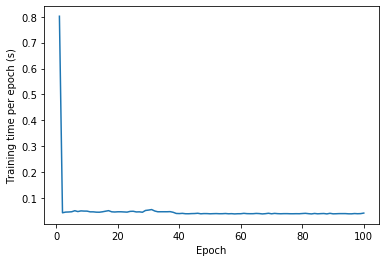

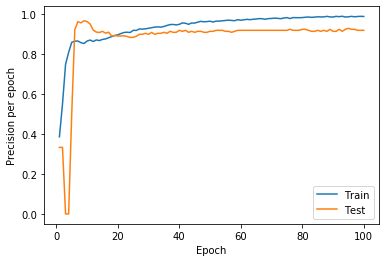

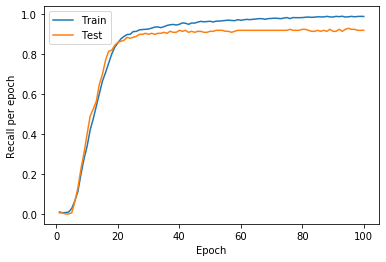

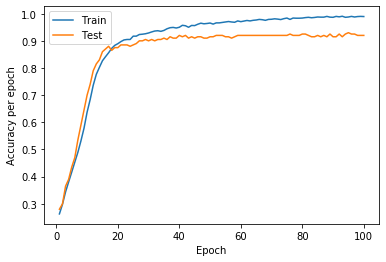

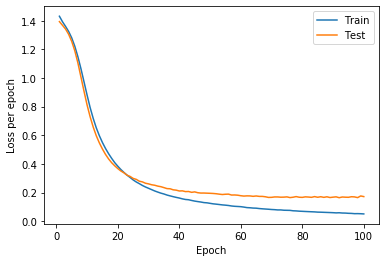

In [10]:
tracker.get_metrics(['avg_training_time', 
                     'best_precision',
                     'best_recall',
                     'best_accuracy',
                     'best_loss',
                     'total_training_time', 
                     'training_time_plot',
                     'precision_plot',
                     'recall_plot',
                     'accuracy_plot',
                     'loss_plot'], 
                    show=True, save=True)

Easy like that! The implementation is still quite raw: there are not so many metrics implemented, and only for basic classification and regression tasks. However, there is an abstract class `Metrics` with all the basic functionality implemented in the file `abstract.py`, so new extensions can easily be created as needed.